
# Project: Investigating Medical Appointment No-Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

For this project, I will be looking at a selection of doctor's appointment attendance records. The data is taken from a collection of offices in Brazil and consists of entries recorded in the summer of 2016. After preparing and cleaning this set, I want to determine what patient factors most contribute to a person showing up, or not showing up, for their doctor's appointment. At the conclusion of this report, I hope to apply the findings to an unseen segment of the data to see if accurate predictions can be made about the behavior of a group of patients.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
% matplotlib inline
palette = sns.color_palette()
palette2 = sns.color_palette('pastel')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

First, I import the raw data to view the first few rows, and call the `.info()` method to learn the total number of entries and intial data types. 

In [2]:
df = pd.read_csv('noshowappointments.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Wow over 100K rows! The columns headers all seem understandable to the context of the data; after consulting the Kaggle Directy, I confirm that column `df.ScheduledDay` is the datetime when the patient requests the appointment listed in `df.AppointmentDay`. Also, I learn that "Scholarship" is an indicator of patients' status in which resepct to to government welfare.

There seem to be a lot of binary values in the set-- either the patient has the characteristic or they don't. It appears that all columns have the same number of non-null entries. Below, I check the basic statistical measurements to get a better understanding of the range of the data.

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.920000e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172615e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173180e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439170e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999820e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


From `.describe()` the min and max for each column appear to be reasonable, except for `df.Age` where there is at least one negative entry. These will need to be removed later.

In [5]:
df.nunique()

PatientId          61744
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

`df.Handcap` should only contain values 1 and 0, so something is up there. I also see that the number of unique `df.PatientId` is about half of than the total number of appointments, meaning that at least of these patients are scheduling multiple appointments. 

Let's look a quick trend of the data. 

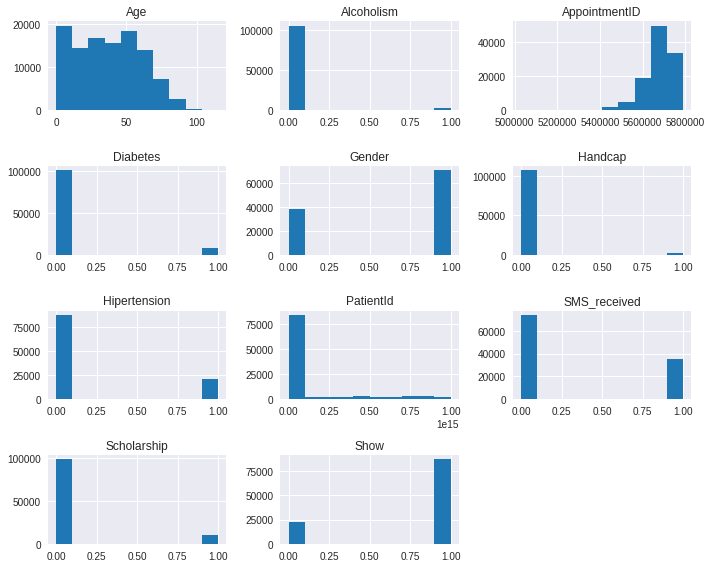

In [33]:
df.hist(figsize=(10,8), color = palette[0]);
plt.style.use('seaborn')
plt.tight_layout()
plt.show()

As noted earlier, a majority of the data exists as binary values. Given this, I plan to use binary correlation values for at least some of my analysis. Also, `df.No-Show` and `df.Gender` were not able to be shown in the set of histograms, because they are objects and not int64.

### Data Cleaning

In [7]:
# 1. Dropping the row with the errant age entry, and dropping all Handcap values > 1.
df.drop(df.loc[df.Age < 0].index, inplace = True)
df.drop(df.loc[df.Handcap > 1].index, inplace = True)

# 2. Renaming "No-Show" column, for clarity. Haha I like envisioning the data "Show". Pesonal preference.
df.rename(columns = {"No-show": "Show"}, inplace = True)

# 3. Tranforming the Gender and Show columns to represented as binary values.
    ## Male is represented as 0 and Female as 1
df.Gender.mask(df.Gender == 'F', 1, inplace = True)
df.Gender.mask(df.Gender == 'M', 0, inplace = True)
df.Gender = df.Gender.apply(pd.to_numeric, errors='coerce')

    ## Show (formerly "No-Show") is 1 and non-attendance is 0
df.Show.mask(df.Show == 'No', 1, inplace = True)
df.Show.mask(df.Show == 'Yes', 0, inplace = True)
df.Show = df.Show.apply(pd.to_numeric, errors='coerce')

# 5. Making dates into dateimes so that they can be more easily manipulated.
from datetime import datetime
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], format = "%Y-%m-%dT%H:%M:%SZ")
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"], format = "%Y-%m-%dT%H:%M:%SZ")

# 6. Creating a separate "test" table and creating a table, "dfb", that is only binary values.
df.reset_index(drop = True, inplace = True)

df_random = df.iloc[::100,:].copy()
df_random.sample(frac=1).reset_index(drop = True, inplace = True) #shuffling the data
df.drop(df.index[::100], inplace = True)

dfb = df.copy()
dfb.drop(columns=["PatientId", "AppointmentID", "Neighbourhood", "ScheduledDay", "AppointmentDay"], inplace = True)

# 7. Structure check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109223 entries, 1 to 110326
Data columns (total 14 columns):
PatientId         109223 non-null float64
AppointmentID     109223 non-null int64
Gender            109223 non-null int64
ScheduledDay      109223 non-null datetime64[ns]
AppointmentDay    109223 non-null datetime64[ns]
Age               109223 non-null int64
Neighbourhood     109223 non-null object
Scholarship       109223 non-null int64
Hipertension      109223 non-null int64
Diabetes          109223 non-null int64
Alcoholism        109223 non-null int64
Handcap           109223 non-null int64
SMS_received      109223 non-null int64
Show              109223 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(10), object(1)
memory usage: 12.5+ MB


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Show
1,5.589980e+14,5642503,0,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4.262960e+12,5642549,1,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,8.679510e+11,5642828,1,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8.841190e+12,5642494,1,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1
5,9.598510e+13,5626772,1,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,1


In [8]:
df.describe()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Show
count,1.092230e+05,1.092230e+05,109223.000000,109223.000000,109223.000000,109223.000000,109223.000000,109223.000000,109223.000000,109223.000000,109223.000000
mean,1.474287e+14,5.675271e+06,0.650229,37.070269,0.098239,0.196808,0.071615,0.030378,0.018568,0.321278,0.798110
std,2.560173e+14,7.132424e+04,0.476900,23.098548,0.297639,0.397588,0.257850,0.171626,0.134992,0.466970,0.401412
min,3.920000e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.168390e+12,5.640247e+06,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.172460e+13,5.680534e+06,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.438360e+13,5.725500e+06,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999820e+14,5.790484e+06,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In the cleanted dataframe, it appears the average Show rate is about 80% across all patients. One point of interest for me is that there are significantly more women in the data than men (women are represented as 1's, and the `df.Gender` mean is 0.65).

<a id='eda'></a>
## Data Analysis

In this section I attempt to identify the patient characteristics that are associated with "Show" behavior.

### Which Variables are Most Strongly Correlated to Attendance?

Given that the majority of the data exist as 1's and 0's, it may be helpful to do an appropriate correlation analysis. Below, the Pearson correlation coefficient is calculated for all patient charactistics (excluding "Neigbourhood", "PatientID", and the datetime columns) with respect to the "Show" observation.

In [9]:
temp = dfb.corr().loc["Show"].reset_index().copy();
show_corr = temp.iloc[temp.Show.abs().argsort()].iloc[::-1].copy();
show_corr.rename(columns={"index": "Parameters", "Show": "\"Show\" Correlation Coefficient"}, inplace = True);
show_corr.reset_index(drop=True, inplace = True);

#New table with correlation coefficients sorted by absolute value
show_corr

,Parameters,"""Show"" Correlation Coefficient"
0,Show,1.000000
1,SMS_received,-0.127213
2,Age,0.060716
3,Hipertension,0.036131
4,Scholarship,-0.029405
5,Diabetes,0.015142
6,Handcap,0.007676
7,Gender,-0.003912
8,Alcoholism,-0.000150


In [10]:
## Determinig statistical significance
import scipy

t=[]
for column in dfb.columns:
    t.append(scipy.stats.pearsonr(df.Show, df[column]))

## For alpha = 0.01, Columns "Handcap","Gender", and "Alcoholism" are not significant

> For alpha = 0.01, a statistical test was applied. Columns "Handcap","Gender", and "Alcoholism" are not significant.

My first observation is that no coefficient appears to be highly correlated with Show. How unfortunate! Second, "SMS-received" is negatively correlated, which doesn't seem like that should be the case. If a patient receives a text reminder, I would expect for their show rate to increase, not the opposite. I will investigate this further, especially given that it has the highest coefficient value.

As an initial look at `df.SMS_received`, I want to check how the values are distributed accross the set. Perhaps there is something I missed in the initial data cleaning. The figure below plots the observation of `df.SMS_recieved == 1` and `df.SMS_recieved == 0` as function of patient's appointment dates along the x axis. Each point represents 1 patient, and whether they received a text message or not. Even if there is not an equal number of 1's and 0's (there won't be) the plot should still be relatively continuous, given the total number of entries available. 

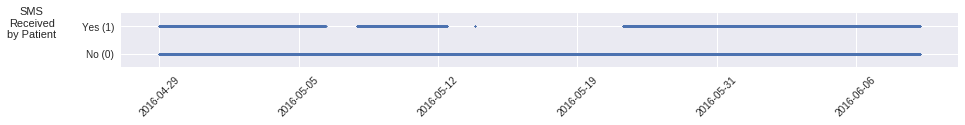

In [11]:
fig1, ax = plt.subplots(1,1, figsize=(15,1))

x1 = df.sort_values('AppointmentDay',ascending=True).AppointmentDay.reset_index(drop=True).reset_index().index.values
y1 = df.sort_values('AppointmentDay',ascending=True).SMS_received.reset_index(drop = True).values
ax.set_xticklabels(['0','2016-04-29','2016-05-05','2016-05-12','2016-05-19','2016-05-31','2016-06-06'], rotation = 45)
ax.set_yticklabels(['','No (0)','Yes (1)'])
ax.set_ylabel('SMS\nReceived\nby Patient', rotation = 0, labelpad = 50)
ax.set_ylim([-.5,1.5])

ax.scatter(x1, y1, marker = '.', s = 5 )

plt.style.use('seaborn-dark')
plt.show()

From the plot, I see two gaps where the data is not continuous. For these regions, either the no patient was sent an SMS, or there was some error in the data entry. I will keep note of this, and see what affect if any it has on the results.

Next, I check the other variables to see if there are similar anomolies. Below are their plots, and they all appear to be continuous.

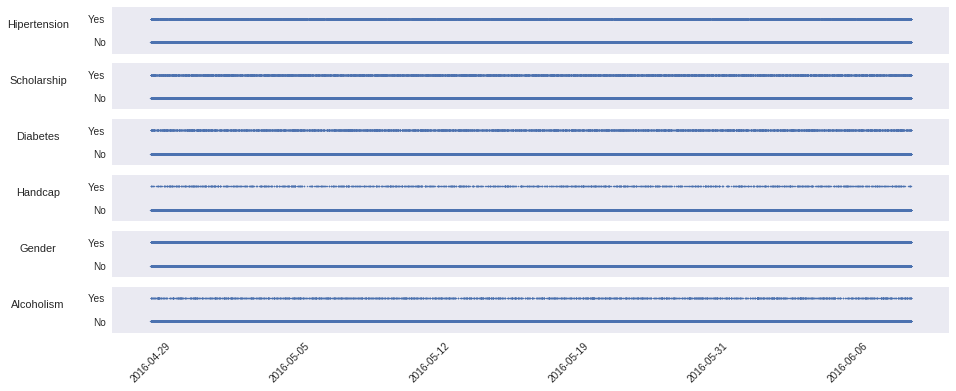

In [12]:
fig11, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1, figsize=(15,6))

y11 = df.sort_values('AppointmentDay',ascending=True).Hipertension.reset_index(drop = True).values
ax1.set_xticklabels([])
ax1.set_yticklabels(['0','No','Yes'])
ax1.set_ylabel('Hipertension', rotation = 0, labelpad = 50)
ax1.set_ylim([-.5,1.5])
ax1.scatter(x1, y11, marker = '.', s = 5 )


y12 = df.sort_values('AppointmentDay',ascending=True).Scholarship.reset_index(drop = True).values
ax2.set_xticklabels([])
ax2.set_yticklabels(['0','No','Yes'])
ax2.set_ylabel('Scholarship', rotation = 0, labelpad = 50)
ax2.set_ylim([-.5,1.5])
ax2.scatter(x1, y12, marker = '.', s = 5 )

y13 = df.sort_values('AppointmentDay',ascending=True).Diabetes.reset_index(drop = True).values
ax3.set_xticklabels([])
ax3.set_yticklabels(['0','No','Yes'])
ax3.set_ylabel('Diabetes', rotation = 0, labelpad = 50)
ax3.set_ylim([-.5,1.5])
ax3.scatter(x1, y13, marker = '.', s = 5 )

y14 = df.sort_values('AppointmentDay',ascending=True).Handcap.reset_index(drop = True).values
ax4.set_xticklabels([])
ax4.set_yticklabels(['0','No','Yes'])
ax4.set_ylabel('Handcap', rotation = 0, labelpad = 50)
ax4.set_ylim([-.5,1.5])
ax4.scatter(x1, y14, marker = '.', s = 5 )

y15 = df.sort_values('AppointmentDay',ascending=True).Gender.reset_index(drop = True).values
ax5.set_xticklabels([])
ax5.set_yticklabels(['0','No','Yes'])
ax5.set_ylabel('Gender', rotation = 0, labelpad = 50)
ax5.set_ylim([-.5,1.5])
ax5.scatter(x1, y15, marker = '.', s = 5 )

y16 = df.sort_values('AppointmentDay',ascending=True).Alcoholism.reset_index(drop = True).values
ax6.set_xticklabels(['0','2016-04-29','2016-05-05','2016-05-12','2016-05-19','2016-05-31','2016-06-06'], rotation = 45)
ax6.set_yticklabels(['0','No','Yes'])
ax6.set_ylabel('Alcoholism', rotation = 0, labelpad = 50)
ax6.set_ylim([-.5,1.5])
ax6.scatter(x1, y16, marker = '.', s = 5 )

plt.style.use('seaborn-dark')
plt.show()

Even with the missing data in `df.SMS_received`, the cause of the negative correlation is still not understood. Below, I slice the data across the time delta between the patients' data they scheduled their appointment and the date of their actual appointment.

In [13]:
near_appt = df.drop(columns=["PatientId","Gender","Age",
                 "Scholarship","Hipertension","Diabetes",
                 "AppointmentID", "Alcoholism", "Handcap",]).loc[abs(df.AppointmentDay-df.ScheduledDay) < 
                                                                pd.to_timedelta(3, unit='D')]
far_appt = df.drop(columns=["PatientId","Gender","Age",
                 "Scholarship","Hipertension","Diabetes",
                 "AppointmentID", "Alcoholism", "Handcap"]).loc[abs(df.AppointmentDay-df.ScheduledDay) > 
                                                                pd.to_timedelta(3, unit='D')]

In [14]:
#df2 will represent the dataframe in which rows that appear to be within the range of no SMS/error data are removed.

df2 = df.drop(df.index[23905:28371]).copy()
df2.drop(df2.index[41368:66558], inplace = True)
df2.reset_index(drop=True, inplace=True)

near_appt2 = df2.drop(columns=["PatientId","Gender","Age",
                 "Scholarship","Hipertension","Diabetes",
                 "AppointmentID", "Alcoholism", "Handcap",]).loc[abs(df2.AppointmentDay-df2.ScheduledDay) < 
                                                                pd.to_timedelta(3, unit='D')]
far_appt2 = df2.drop(columns=["PatientId","Gender","Age",
                 "Scholarship","Hipertension","Diabetes",
                 "AppointmentID", "Alcoholism", "Handcap"]).loc[abs(df2.AppointmentDay-df2.ScheduledDay) > 
                                                                pd.to_timedelta(3, unit='D')]

In [15]:
pd.concat([near_appt.mean(),far_appt.mean()], axis=1, keys=['Days < 3', 'Days > 3'])

,Days < 3,Days > 3
SMS_received,0.017001,0.603793
Show,0.903263,0.700478


Interesting! For patients who schedule their appointments within 3 days of the appointment date, the probability of them receiving a text message is almost zero. Unsurprisingly, the Show rate for these patients scheduling within the 3 day range is 20% higher than those who schedule their appointments further out. This sheds some light on where the negative correlation is coming from. Below, I use the same technique to trend the SMS rate and Show rate for a range of ScheduledDay-AppointmentDay time periods.

In [16]:
Day_Diff = []
for index, row in df.iterrows():
    Day_Diff.append(row.AppointmentDay-row.ScheduledDay)
df.insert(5,'Day_Diff', Day_Diff)

from numpy import array

array = array([-1,0,1,2,3,5,10,20,30,60])
count = 0
delta = [0]*len(array)
for x in array:
    delta[count]=pd.to_timedelta(x, unit='D')
    count = count + 1

daydiff_bins = pd.cut(df.Day_Diff, bins=delta)
daydiff_bins_show_sms = pd.concat([daydiff_bins, df.Show, df.SMS_received], axis=1)
tbl = daydiff_bins_show_sms.groupby(["Day_Diff"]).mean().copy()

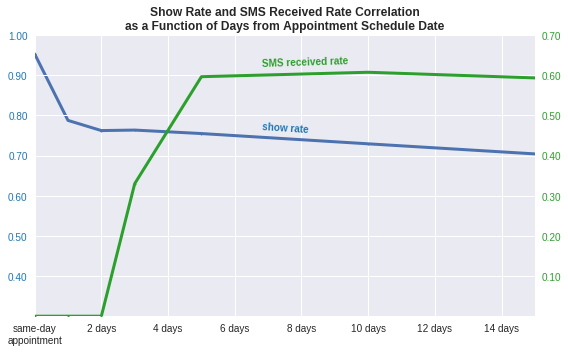

In [32]:
from matplotlib.ticker import FormatStrFormatter
fig2, ax1 = plt.subplots(1,1,figsize=(8,5))
plt.style.use('seaborn')

newarray = np.delete(array, 0)
ax1.set_title('Show Rate and SMS Received Rate Correlation\nas a Function of Days from Appointment Schedule Date', fontweight ='bold')
ax1.set_xlim([0,15])
ax1.set_xticklabels(['same-day\nappointment', '2 days', '4 days', '6 days', '8 days', '10 days', '12 days', '14 days'])
ax1.set_ylim([0.3, 1])
ax1.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_yticklabels(['0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00'],color=palette[0])
ax1.plot(newarray, tbl.Show.values, marker = 'o', linewidth=3, markersize = 2)

ax2 = ax1.twinx() 
ax2.set_ylim([0, 0.7])
ax2.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, .7])
ax2.set_yticklabels(['0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70'],color=palette[2])
ax2.plot(newarray, tbl.SMS_received.values, marker = 'o', linewidth=3, markersize = 2, color = palette[2])

ax1.text(6.8, .765, 'show rate', color = palette[0], rotation = -3.8, fontweight='bold' )
ax2.text(6.8, .63, 'SMS received rate', color = palette[2], rotation = 1.9, fontweight='bold' )

fig2.tight_layout()
plt.style.use('seaborn')
plt.show()

It appears that the doctor's officies begin sending text messages around the 3 day mark, and their patients receive the messages at a relatively constant rate of 0.60 after the 5 day mark. Because the show rate continues to decrease, the negative correlation between `df.SMS_revceived` and `df.Show` is observed. 

I want to see the effect of SMS messages when the rate of them being received is constant. If the text reminders are effective, there should be an increase in show rate for those who receive the message and those who do not. In the figure below, I also include the "cleaned" SMS results, i.e. a separate dataframe where the regions of unexpected 0's are removed.

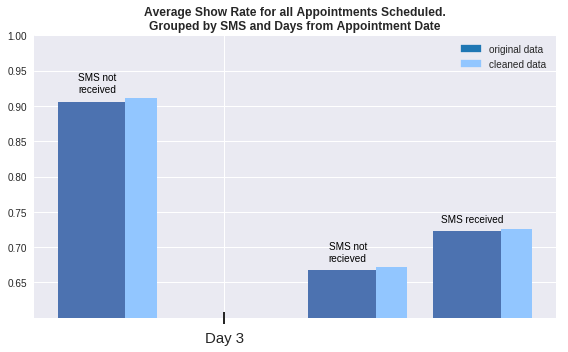

In [18]:
from matplotlib.ticker import FormatStrFormatter #needed to set decimal place of axis labels
fig3, ax3 = plt.subplots(1,1,figsize=(8,5))

#temporary variables
width = .2
width2 = .075
x2=np.array([1,1.6,1.9])

ax3.set_title('Average Show Rate for all Appointments Scheduled.\nGrouped by SMS and Days from Appointment Date', fontweight = 'bold')
ax3.set_ylim([0.6, 1])
ax3.set_yticks([0.65,0.7,0.75,0.8,0.85,0.9,0.95,1])
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.set_xticks([1.3])
ax3.set_xticklabels(['Day 3'], fontsize = 15)
ax3.tick_params(axis='x', direction = 'inout', length = 12, width = 2)
ax3.bar(x2, [near_appt.loc[df.SMS_received==0].Show.mean(), 
                                 far_appt.groupby("SMS_received").mean().iloc[0].item(),
                                 far_appt.groupby("SMS_received").mean().iloc[1].item()], width)
ax3.bar(x2+width/2, [near_appt2.loc[df2.SMS_received==0].Show.mean(), 
                                 far_appt2.groupby("SMS_received").mean().iloc[0].item(),
                                 far_appt2.groupby("SMS_received").mean().iloc[1].item()], width2, color = palette2[0])
ax3.text(.95,.92, 'SMS not\nreceived', color = 'black')
ax3.text(1.55,.68, 'SMS not\nrecieved', color = 'black')
ax3.text(1.82,.735, 'SMS received', color = 'black')

#Defining legend here
colors = {'original data':palette[0], 'cleaned data':palette2[0]}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax3.legend(handles, labels)

fig3.tight_layout()
plt.style.use('seaborn')
plt.show()

When the doctor's offices send reminder text messages at a more contant rate, it appears that the show rate is about 5% higher for patients. This positively correlated behavior is what I would expect. One interesting note is that the cleaned data does not really affect the overall result in this case. 

The next hightest-correlated patient factor was age. I will group the data by age to see if there is more information that can be determined.

In [19]:
age_bins = pd.cut(df.Age, bins=[0, 5, 20, 35, 50, 65, 80, 95, 115])
age_bins_show = pd.concat([age_bins, df.Show], axis=1)
tbl2 = age_bins_show.groupby(["Age"]).mean().T

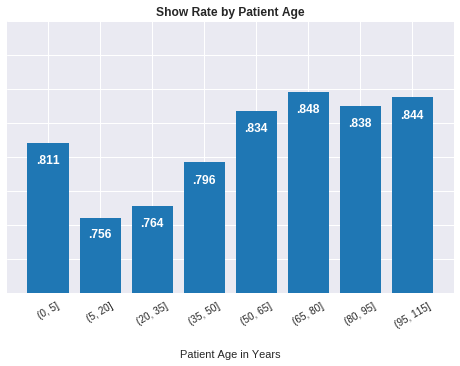

In [20]:
fig4, ax4 = plt.subplots(1,1,figsize=(8,5))

#temporary vairbles
plotx = tbl2.T.reset_index()
count=1

ax4.set_title('Show Rate by Patient Age', fontweight= 'bold')
ax4.set_ylim([0.7, .9])
ax4.set_yticklabels('')
ax4.set_xticklabels(['','(0, 5]', '(5, 20]', '(20, 35]', '(35, 50]', '(50, 65]', '(65, 80]', '(80, 95]', '(95, 115]'], rotation = 30)
ax4.set_xlabel('Patient Age in Years', labelpad = 20)
ax4.grid(True)
ax4.bar(plotx.index.values, tbl2.T.Show.values, color = palette[0])

#writing text labels
for x in range(len(tbl2.T)):
    ax4.text(x-.23, tbl2[count].round(decimals=3).item()- 0.015, str(tbl2[count].round(decimals=3).item()).strip('0'), fontsize = 12, fontweight = 'bold', color = 'white')
    count = count + 15 #because groupby keeps all entried when referencing the object. Weird!   

plt.style.use('seaborn')
plt.show()

After age (0,5] , the Show rate increases through age (65,80] before appearing to plateau or perhaps slightly drop off. For a patient in the (65,80] age group, their Show rate is almost 10% higher than for those in the (5,20] group.

In [21]:
temp = dfb.corr().loc["Age"].reset_index().copy();
age_corr = temp.iloc[temp.Age.abs().argsort()].iloc[::-1].copy();
age_corr.rename(columns={"index": "Parameters", "Age": "\"Age\" Correlation Coefficient"}, inplace = True);
age_corr.reset_index(drop=True, inplace = True);
age_corr

,Parameters,"""Age"" Correlation Coefficient"
0,Age,1.000000
1,Hipertension,0.503719
2,Diabetes,0.291674
3,Gender,0.106726
4,Alcoholism,0.095470
5,Scholarship,-0.092073
6,Handcap,0.082138
7,Show,0.060716
8,SMS_received,0.012895


In [22]:
age_bins_all = pd.concat([age_bins, df.Hipertension, df.Diabetes, df.Gender, df.Alcoholism], axis=1)

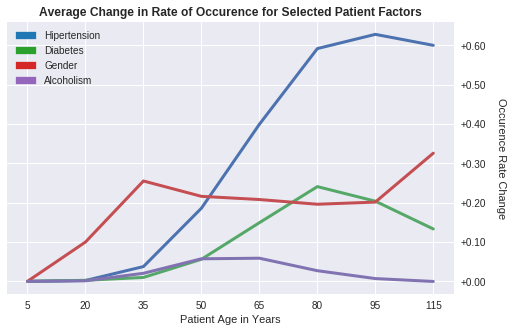

In [23]:
fig5, ax5 = plt.subplots(1,1, figsize=(8,5))

ax5.set_title('Average Change in Rate of Occurence for Selected Patient Factors', fontweight= 'bold')
ax5.set_xlabel('Patient Age in Years')
ax5.set_xticklabels(['0','5','20','35','50','65','80', '95', '115'])
ax5.set_ylabel('Occurence Rate Change', labelpad = 20, rotation = -90)
ax5.yaxis.set_major_formatter(FormatStrFormatter('+%.2f'))
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.plot(age_bins_all.groupby(["Age"]).mean().Hipertension.values, linewidth=3)
ax5.plot(age_bins_all.groupby(["Age"]).mean().Diabetes.values, linewidth=3)
ax5.plot(age_bins_all.groupby(["Age"]).mean().Gender.values-.474, linewidth=3)
ax5.plot(age_bins_all.groupby(["Age"]).mean().Alcoholism.values, linewidth=3)

#Defining legend here
colors = {'Hipertension':palette[0], 'Diabetes':palette[2], 'Gender':palette[3],'Alcoholism':palette[4], }  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax5.legend(handles, labels)

plt.show()

The table and figure above show that a few of the patient factors are stongly correlated with Age. This makes sense, and suggests that a patient's age can be a proxy for these other factors when determining Show rate. 

In the figure, I find it interesting how the share of women showing up to appointments increases with age. 

In [24]:
show_corr

,Parameters,"""Show"" Correlation Coefficient"
0,Show,1.000000
1,SMS_received,-0.127213
2,Age,0.060716
3,Hipertension,0.036131
4,Scholarship,-0.029405
5,Diabetes,0.015142
6,Handcap,0.007676
7,Gender,-0.003912
8,Alcoholism,-0.000150


Returning to the original correlation table above, I have collected a more detailed understanding of SMS_received, Age, and Hipertension+Diabetes (which are correlated with Age), which make up the top 5 indicators. Lastly, I will look at Scholarship status. 

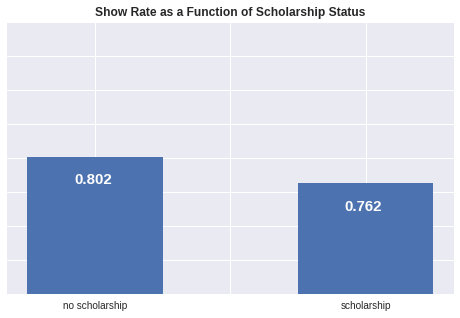

In [25]:
fig6, ax6 = plt.subplots(figsize = (8,5))

#temp variable
width3 = .5

ax6.set_title('Show Rate as a Function of Scholarship Status', fontweight = 'bold')
ax6.set_ylim([0.6, 1])
ax6.set_xticks([-.5,0,.5,1,1.5])
ax6.set_yticklabels('')
ax6.set_xticklabels(['','no scholarship','','scholarship',''])
ax6.set_ylabel('')
ax6.bar(df.groupby(["Scholarship"]).Show.mean().index.values,df.groupby(["Scholarship"]).Show.mean().values, width3)

ax6.text(-.078,df.groupby(["Scholarship"]).Show.mean().values[0]-0.04,str(df.groupby(["Scholarship"]).Show.mean().round(decimals = 3).values[0]), fontweight = 'bold', fontsize = 15, color = 'white')
ax6.text(1-.078,df.groupby(["Scholarship"]).Show.mean().values[1]-0.04,str(df.groupby(["Scholarship"]).Show.mean().round(decimals = 3).values[1]), fontweight = 'bold', fontsize = 15, color = 'white')
ax6.grid(True)

plt.style.use('seaborn')

The Show rate is 4% lower for those who are on government assistance. There are a range of factors as to why this is the case, but give the available data, I'm not sure if there is more I can investigate. Since the patients' neighbourhood information in given, it would be helpful if there were information their distance from the doctor's offices or information on with neighbourhoods were closer together than others, to see if their was some relationship with Show rate.

### Given a Patient Profile, Can Attendance be Predicted?

From the start, it was apparent that a majority of patients attend their appointments. Even when the data was sliced in different ways, the trend did not have any huge swings. This is obviously good news, but it's not too helpful when trying to make a prediction, especially for an individual patient.

One thing that I think can be done though is to predict the number Shows/No-Shows across a group of patients, with a limited number of inputs. For example, if a doctor's office has a number appointments a week out, can the number of shows be estimated? If so, that information may be helpful for stocking supplies, staffing, or related logistical planning.

In [26]:
#df_test represents all entries within the df_random that can be considered "a week out" from their schedule date.
df_test = df_random.loc[abs(df_random.AppointmentDay-df_random.ScheduledDay) >= pd.to_timedelta(7, unit='D')].copy()
df_test = df_test.loc[abs(df_random.AppointmentDay-df_random.ScheduledDay) < pd.to_timedelta(15, unit='D')]
df_test.reset_index(drop=True, inplace = True)
df_test.shape #check how many rows there are to work with

(139, 14)

In [27]:
tempdf = df.loc[abs(df.AppointmentDay-df.ScheduledDay) >= pd.to_timedelta(7, unit='D')].copy()
tempdf = tempdf.loc[abs(df.AppointmentDay-df.ScheduledDay) < pd.to_timedelta(15, unit='D')]

age_bins2 = pd.cut(tempdf.Age, bins = 15)
age_bins_show2 = pd.concat([age_bins2, tempdf.Show], axis=1)
age_rate_table = age_bins_show2.groupby(["Age"]).mean()
age_rate_table.reset_index(drop=False, inplace=True)

In the code above, I prepare a new dataframe `age_rate_table`. This table contains two columns, the first age ranges (interval datatype) taken from the original `df`, and the second column is the matching mean Show rate for each of those age ranges.

With this information, I can create a function that predicts the mean Show rate for a group of patients in the df_test datatframe. I plan to use only three inputs to make the prediction: the patient's age, their scholarship status, and whether they received an SMS message. I chose these three becuase they were the highest statistically significant correlations that do appear to strongly correlate with each other. They are not perfectly independent, but perhaps they can be treated as such to make predictions. Indepedent variables can have their rates can be summed. This what I do in the function below-- first a "base" rate is found via the patients' age, then depending on their SMS/Scholarship status, the base value is biased. The biases, `r_schol` and `r_sms`, represent the average change in the Show rate with respect to Scholarship and SMS as determined in the preceding analysis.

In [28]:
def compare(case):
    
    rsum = []
    r_schol = lambda i : -0.040 if case.Scholarship[i] == 1 else 0
    r_sms = lambda i : 0.053 if case.SMS_received[i] == 1 else 0
    r_age = 0
    match = False
    total = len(case)
    
    for i in case.index:
        counter = 0
        while match is False:
            r_age = age_rate_table.iloc[counter,1]
            match = case.Age[i] in age_rate_table.iloc[counter,0]
            counter += 1
        rsum.append(r_schol(i)+r_sms(i)+r_age)
    rsum_array = np.array(rsum)
    pmean = rsum_array.mean()
    pshows = pmean*total
    
    ashows = case[case.Show==1].Show.count()
    amean = ashows/total
    
    result = pd.DataFrame({'Total Appts': [total,total, '--'], 'Total Shows': [pshows,ashows,abs(pshows-ashows)], 'Mean Show rate': [pmean,amean, abs(pmean-amean)]}, index = ['Predicted', 'Actual', 'Diffence'])
    display(result)

Now, `df_test` is divided into three subsets for testing.

In [29]:
case1 = df_test.iloc[0::3].copy()
case2 = df_test.iloc[1::3].copy()
case3 = df_test.iloc[2::3].copy()

In [30]:
print(compare(case1),compare(case2), compare(case3));

,Total Appts,Total Shows,Mean Show rate
Predicted,47,32.74518,0.696706
Actual,47,30.00000,0.638298
Diffence,--,2.74518,0.058408


,Total Appts,Total Shows,Mean Show rate
Predicted,46,31.810195,0.691526
Actual,46,33.000000,0.717391
Diffence,--,1.189805,0.025865


,Total Appts,Total Shows,Mean Show rate
Predicted,46,31.857868,0.692562
Actual,46,32.000000,0.695652
Diffence,--,0.142132,0.003090


None None None


Not too shabby of a result! Avg %diff is 3.4 percent.

<a id='conclusions'></a>
## Conclusions

From this analysis it was determined that receiving an SMS had the highest magnitude correlation with a patient showed up to their appointment. Unexpectedly, this correlation was found to be negative. Later investigation showed that the number of days between a patient scheduling an appoinment determined wheter a patient recieved an SMS, and accounted for negative correlation. Relatedly, it was found that the time delay between scheduled days and appointment days was as siginificant contributor to the decrease in Show rate. The mean show rate for patients who did recieve an SMS is 5% higher for patients who schedule more than 3 days out. 

Age was also determined to be a significant contributor to Show rate. Across the age bucket analyzed the rate change was as large as 9%. Lastly, Scholarship status was found to be negatively correlated with the Show rate, and patients who recieved scholarship were 4% less likely to attend their appointments.

Using Age, SMS reception, and Scholarship status, the number of Shows for a sample of patients can be predicted with a relative high degree of accuracy. The prediction equation used in this analysis managed a 3.4% differnce of the three samples tested. 

In [34]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0